In [155]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset

import torchvision as tv
import PIL.Image as Image

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [185]:
class LeafDataset(Dataset):
    def __init__(self, images_dir, dataframe, transform=None):
        self.images_dir = images_dir
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = str(int(self.dataframe.iloc[idx]['id'])) + ".jpg"
        img_dir = os.path.join(self.images_dir, img_name)

        # image = Image.open(img_dir)
        # read_image returns a tensor
        # no need for transforms.ToTensor()
        img = tv.io.read_image(img_dir) 
        if self.transform: img = self.transform(img)

        label = self.dataframe.iloc[idx]['species']
        label = label.astype('long')
        return img, label

In [186]:
t.manual_seed(0)

img_dir = '../../datasets/leaf-classification/images/'
csv_dir = '../../datasets/leaf-classification/train.csv'

img_filenames_list = os.listdir(img_dir)
dataframe = pd.read_csv(csv_dir)
dataframe['species'] = dataframe['species'].astype('category').cat.codes
dataframe.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,3,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,49,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,65,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,94,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,84,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [187]:
dataframe['species'].value_counts()

3     10
26    10
2     10
39    10
0     10
      ..
12    10
88    10
27    10
36    10
91    10
Name: species, Length: 99, dtype: int64

In [188]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
BATCH_SIZE = 16
TEST_SIZE = 0.2
NUM_DATASET_REPEAT = 5

train_df, test_df = train_test_split(dataframe, test_size=TEST_SIZE)

In [189]:
train_transform = tv.transforms.Compose([
    tv.transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(90),
    tv.transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    # tv.transforms.ToTensor(), # using read_image already converts to tensor
])

test_transform = tv.transforms.Compose([
    tv.transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(90),
    tv.transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
])  

train_ds = LeafDataset(img_dir, dataframe=train_df, transform=train_transform)
test_ds = LeafDataset(img_dir, dataframe=test_df, transform=test_transform)

# increase the size of the dataset by repeating the data 
# while augmenting each of them slightly differently
augmented_train_ds = ConcatDataset([train_ds for _ in range(NUM_DATASET_REPEAT)])
augmented_test_ds = ConcatDataset([test_ds for _ in range(NUM_DATASET_REPEAT)])

train_dl = DataLoader(augmented_train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(augmented_test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [192]:
img, label = next(iter(train_dl))
print("Total train:", len(train_dl))
print("Total test:", len(test_dl))
print("Batch shape:", img.shape)
print("Label shape:", label.shape)

Total train: 248
Total test: 62
Batch shape: torch.Size([16, 1, 128, 128])
Label shape: torch.Size([16])


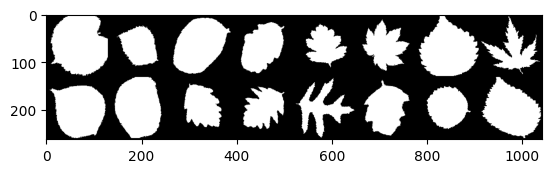

In [191]:
# make a grid from batch
out = tv.utils.make_grid(img)
plt.imshow(out.numpy().transpose((1, 2, 0)))